In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from astropy.io import fits

#DATOS CÚMULO 32

#ra = 328.4 deg
#dec = 17.695 deg
#R = 9.29 arcmin
#z = 0.23

file_path = 'merged_manipulado.csv' 
#Archivo catálogos unidos con las magnitudes corregidas (+ erroes), flujos en microJy (+errores) (u,g,r,i,z)
df = pd.read_csv(file_path)

In [2]:
#Filtro por cercanía al centró del cúmulo
ra_centro_rad = np.radians(328.4)  
dec_centro_rad = np.radians(17.695)  

radio_deseado_arcmin = 6.0 #radio_deseado
radio_deseado_rad = np.radians(radio_deseado_arcmin / 60.0) 

df['ra_rad'] = np.radians(df['ra']) #paso de grados a radianes mis datos
df['dec_rad'] = np.radians(df['dec'])

# Función para calcular la distancia angular entre dos puntos en la esfera
def distancia_angular(ra1, dec1, ra2, dec2):
    cos_d = np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
    return np.arccos(cos_d)

df['distancia_angular'] = distancia_angular(ra_centro_rad, dec_centro_rad, df['ra_rad'], df['dec_rad'])

#df con galaxias cercanas al centro del cúmulo
centrales = df[df['distancia_angular'] <= radio_deseado_rad]

print("Elementos totales:", len(df))
print("Elementos centrales:", len(centrales))
df.head()


Elementos totales: 1982
Elementos centrales: 1257


,ra_1,dec_1,type_1,dered_mag_g,dered_mag_i,dered_mag_r,dered_mag_z,flux_g,flux_i,flux_r,...,err_mag_w2,err_mag_w3,err_mag_w4,err_flux_w1,err_flux_w2,err_flux_w3,err_flux_w4,ra_rad,dec_rad,distancia_angular
0,328.311924,17.596994,PSF,23.278328,21.562424,21.747995,21.349037,1.862387,10.156627,6.198191,...,0.508633,-0.153043,0.290478,11.364722,25.757712,699.775734,12498.750669,5.730124,0.307126,0.002252
1,328.315270,17.598927,REX,22.267968,21.004854,21.387075,21.040977,5.235264,14.700445,10.922053,...,0.259537,0.641537,0.758658,11.275095,25.671737,714.892732,12591.265389,5.730182,0.307160,0.002190
2,328.303323,17.604284,REX,23.551718,21.876404,21.900555,21.237907,1.682648,7.851946,5.469043,...,1.404041,1.284913,1.306026,10.871430,24.972241,700.926382,12505.255619,5.729974,0.307253,0.002256
3,328.302643,17.605979,EXP,22.475948,21.945464,21.762905,21.364947,3.341826,7.630347,6.394537,...,1.683393,3.748192,-1.195135,10.917706,25.258162,707.270796,12555.479792,5.729962,0.307283,0.002244
4,328.316483,17.602162,PSF,24.615448,21.567554,22.367035,20.772577,0.575497,8.057189,2.785368,...,-1.764937,-2.145326,4.637750,11.027900,24.890542,699.443210,12685.285156,5.730204,0.307215,0.002135


In [3]:
#Tengo información de elementos que no son objetos, sino píxeles saturados.
#Filtro de píxeles saturados, etc:
objetos = centrales[(centrales['dered_mag_u'] < 30) & (centrales['dered_mag_u'] > -30) &
                 (centrales['dered_mag_g'] < 30) & (centrales['dered_mag_g'] > -30) &
                 (centrales['dered_mag_r'] < 30) & (centrales['dered_mag_r'] > -30) &
                 (centrales['dered_mag_i'] < 30) & (centrales['dered_mag_i'] > -30) &
                 (centrales['dered_mag_z'] < 30) & (centrales['dered_mag_z'] > -30)]
print("Objetos centrales:", len(objetos))


Objetos centrales: 1235


/var/folders/kq/y0nm7vr15gj7j16l_gl_36ch0000gn/T/ipykernel_12008/3073714553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objetos['color_gr'] = objetos['dered_mag_g'] - objetos['dered_mag_r'] #color r-i de cada galaxia


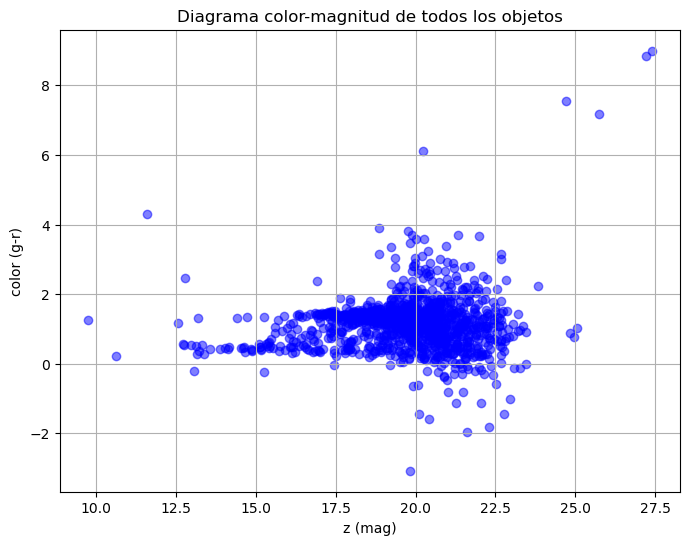

In [4]:
objetos['color_gr'] = objetos['dered_mag_g'] - objetos['dered_mag_r'] #color r-i de cada galaxia

#Diagrama color magnitud de los objetos de mi cúmulo
plt.figure(figsize=(8, 6))
plt.scatter(objetos['dered_mag_z'], objetos['color_gr'], color='blue', alpha=0.5)  
plt.xlabel('z (mag)')  
plt.ylabel('color (g-r)')  
plt.title('Diagrama color-magnitud de todos los objetos')
plt.grid(True)
plt.show()  


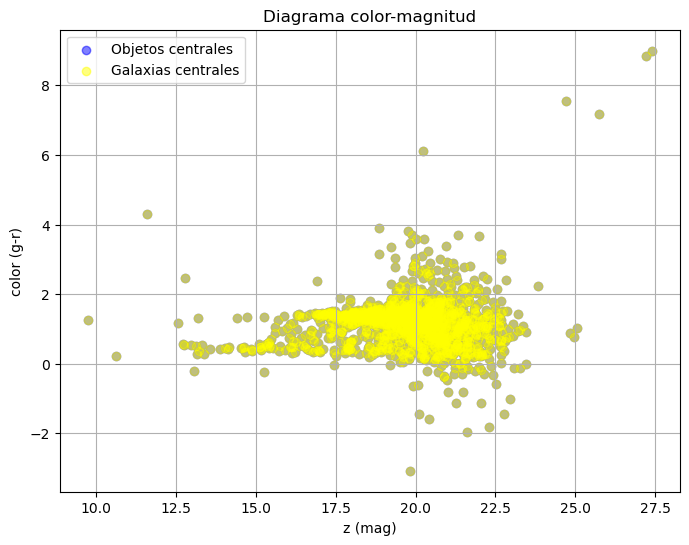

Galaxias centrales 1235


In [5]:
#Algunos elementos, aunque son objetos (no fallos del instrumento de observación) pueden no ser galaxias.
#Legacy Survey incluye un parámetro llamado "type" que me da información sobre la distribución espectral del objeto.
#Puedo suponer casi seguro que aquellos del tipo PSF (distribución puntual) seán estrellas:
galaxias = objetos[(objetos['type_2'] != 'PSF') & (objetos['type_1'] != 6)]

plt.figure(figsize=(8, 6))
plt.scatter(objetos['dered_mag_z'], objetos['color_gr'], color='blue', alpha=0.5, label='Objetos centrales')
plt.scatter(galaxias['dered_mag_z'], galaxias['color_gr'], color='yellow', alpha=0.5, label='Galaxias centrales')

plt.xlabel('z (mag)')
plt.ylabel('color (g-r)')
plt.title('Diagrama color-magnitud')
plt.grid(True)
plt.legend()
plt.show()


print("Galaxias centrales", len(galaxias))


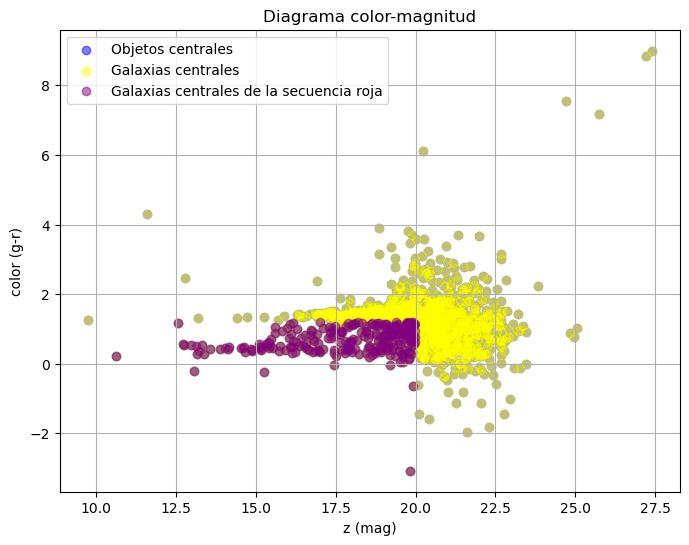

Galaxias centrales pertenecientes a la secuencia roja: 270


In [6]:
#Basándome en el artículo https://arxiv.org/pdf/1709.01136.pdf , en el que aparece un cúmulo de redshift intermedio
#(z = 0.18) similar al mío (z = 0.23) puedo imponer límites de magnitud z y color (g-r) para acotar los objetos de
#tal manera que me quede con aquellas galaxias que pertenezcan en su gran mayoría a la secuencia roja:
sr = galaxias[(galaxias['dered_mag_z'] <= 20) & 
              #(galaxias['color_gr'] >= 0.8) & 
              (galaxias['color_gr'] <= 1.2)]

plt.figure(figsize=(8, 6))
plt.scatter(objetos['dered_mag_z'], objetos['color_gr'], color='blue', alpha=0.5, label='Objetos centrales')
plt.scatter(galaxias['dered_mag_z'], galaxias['color_gr'], color='yellow', alpha=0.5, label='Galaxias centrales')
plt.scatter(sr['dered_mag_z'], sr['color_gr'], color='purple', alpha=0.5, label='Galaxias centrales de la secuencia roja')

plt.xlabel('z (mag)')
plt.ylabel('color (g-r)')
plt.title('Diagrama color-magnitud')
plt.grid(True)
plt.legend()
plt.show()

print("Galaxias centrales pertenecientes a la secuencia roja:", len(sr))


In [7]:
#Esto me sirve para comprobar que los objetos (realmente la mayoría, pues tengo que contar con que hay objetos
#contaminantes) de la secuencia roja de mi cúmulo tienen un redshift que concuerda con el que sé que tiene mi
#cúmulo. Una vez comprobado eso puedo imponer esa condición para buscar galaxias fuera de la secuencia roja.


In [8]:
#También puedo filtrar por diagrama coor-color para acotar aún más la SR. Me baso en los límites marcados en 
# https://arxiv.org/pdf/astro-ph/0107201.pdf
#-> red galaxies (u∗ − r∗> 2.22)

#Estudios teóricos de síntesis de poblaciones sugieren que el color u∗ − r∗ sigue siendo un buen discriminador 
#en el rango de corrimiento al rojo considerado (z ≤ 0.4).

sr.loc[:, 'color_ur'] = sr['dered_mag_u'] - sr['dered_mag_r']
srr = sr[sr['color_ur'] >= 2.22].copy()

print("Galaxias centrales pertenecientes a la secuencia roja (más filtrada):", len(srr))
srr.head()

Galaxias centrales pertenecientes a la secuencia roja (más filtrada): 126


/var/folders/kq/y0nm7vr15gj7j16l_gl_36ch0000gn/T/ipykernel_12008/3999477293.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr.loc[:, 'color_ur'] = sr['dered_mag_u'] - sr['dered_mag_r']


,ra_1,dec_1,type_1,dered_mag_g,dered_mag_i,dered_mag_r,dered_mag_z,flux_g,flux_i,flux_r,...,err_mag_w4,err_flux_w1,err_flux_w2,err_flux_w3,err_flux_w4,ra_rad,dec_rad,distancia_angular,color_gr,color_ur
83,328.314321,17.660862,EXP,20.980678,19.418034,19.833725,19.077057,11.279415,59.383785,37.674348,...,-0.418838,12.759011,26.978287,696.504783,12061.095243,5.730166,0.308240,0.001544,1.146953,5.77412
92,328.307484,17.684091,PSF,20.275968,19.203584,19.456245,19.061257,22.060721,69.208222,52.210505,...,0.863326,11.280741,25.169436,655.094187,11705.105339,5.730047,0.308646,0.001550,0.819723,2.95234
142,328.398157,17.595352,PSF,13.861058,13.088624,13.649675,10.607697,19874.541021,102442.957068,69751.346605,...,0.301845,200.008884,220.195544,655.488872,11728.981832,5.731629,0.307097,0.001740,0.211383,10.53368
143,328.372066,17.603627,REX,20.714788,19.880844,20.057955,19.486937,12.739912,0.000000,26.649793,...,0.730372,12.196677,26.296367,662.369675,11730.235640,5.731174,0.307241,0.001661,0.656833,2.72319
144,328.373271,17.605174,PSF,17.866648,17.033424,17.261055,16.956807,184.059954,236.675065,366.529007,...,0.004519,13.872900,26.677219,659.466899,11683.052096,5.731195,0.307268,0.001629,0.605593,2.36511


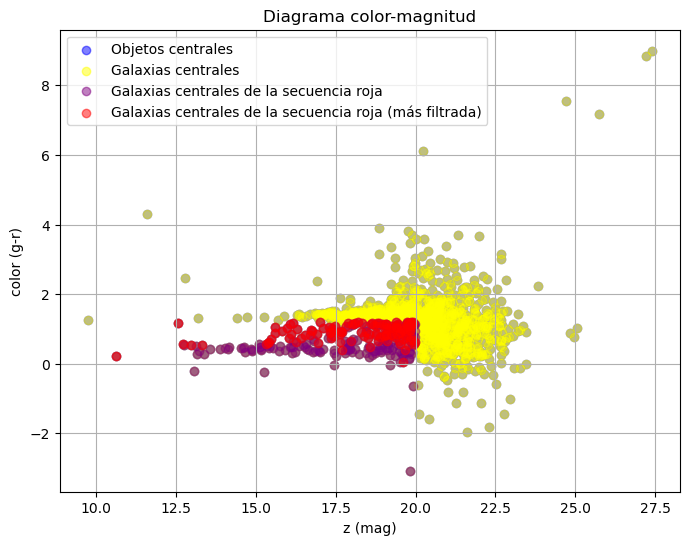

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(objetos['dered_mag_z'], objetos['color_gr'], color='blue', alpha=0.5, label='Objetos centrales')
plt.scatter(galaxias['dered_mag_z'], galaxias['color_gr'], color='yellow', alpha=0.5, label='Galaxias centrales')
plt.scatter(sr['dered_mag_z'], sr['color_gr'], color='purple', alpha=0.5, label='Galaxias centrales de la secuencia roja')
plt.scatter(srr['dered_mag_z'], srr['color_gr'], color='red', alpha=0.5, label='Galaxias centrales de la secuencia roja (más filtrada)')

plt.xlabel('z (mag)')
plt.ylabel('color (g-r)')
plt.title('Diagrama color-magnitud')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
#Creo un archivo .csv con los datos necesarios para bagpipes:
# ()

#columnas_deseadas = ['flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z',
#                    'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z',
#                    'flux_w1', 'flux_w2', 'flux_w3', 'flux_w4',
#                    'err_flux_u', 'err_flux_g', 'err_flux_r', 'err_flux_i', 'err_flux_z',
#                    'err_flux_u', 'err_flux_g', 'err_flux_r', 'err_flux_i', 'err_flux_z',
#                    'err_flux_w1', 'err_flux_w2', 'err_flux_w3', 'err_flux_w4']


# Crea un nuevo DataFrame con las columnas seleccionadas y en el orden deseado
red_sec = srr[columnas_deseadas].copy()

# Muestra el nuevo DataFrame
print(red_sec)

NameError: name 'columnas_deseadas' is not defined

In [ ]:
ruta_archivo = 'red_sec3.txt'
red_sec.to_csv(ruta_archivo, index=False, header=False, sep=' ') 

In [ ]:
ruta_archivo = 'red_sec4.csv'
red_sec.to_csv(ruta_archivo, index=False, header=False, sep=' ') 
print("DataFrame guardado en", ruta_archivo)

In [ ]:
ruta_archivo = 'red_sec5.txt'
red_sec.to_csv(ruta_archivo, index=False, header=False, sep=' ') 
print("DataFrame guardado en", ruta_archivo)

In [ ]:
ruta_archivo = 'red_sec6.txt'
red_sec.to_csv(ruta_archivo, index=False, header=False, sep=',') 
print("DataFrame guardado en", ruta_archivo)